In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
keras = tf.keras
from keras import Sequential
from keras.layers import Dense, InputLayer, Dropout
from keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# extract data and target
X = heart_disease.data.features  # Features
y = heart_disease.data.targets   # Target variable

# targets that are 1-4, are now just equal to 1.
y = (y > 0).astype(int)

# select the 13 features (update these indices or column names based on the dataset)
selected_features = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal"
]

# using only the selected features
X = X[selected_features]

# handle missing values by imputing them with the column mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

2024-12-10 20:26:59.642734: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 20:26:59.951339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733891220.064020     985 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733891220.104867     985 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 20:27:00.379248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def build_model(num_hidden_layers=3, num_neurons=32, dropout_rate=0.0, momentum=0.0):
    model = Sequential()
    model.add(InputLayer(shape=(X_scaled.shape[1],)))
    model.add(Dropout(rate=dropout_rate))
    for _ in range(num_hidden_layers):
        model.add(Dense(num_neurons, activation='relu')) # Hidden layer using ReLU activation function
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid')) # Output layer using sigmoid activation function
    optimizer = SGD(learning_rate=0.01, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

param_grid = {
    'model__num_hidden_layers': [1, 2, 3],
    'model__num_neurons': [64, 128],
    'model__dropout_rate': [0.1, 0.3],
    'model__momentum': [0.5, 0.9]
}

model = KerasClassifier(model=build_model, epochs=50, batch_size=10, verbose=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, verbose=5) # Grid search with 5-fold cross-validation
grid_search.fit(X_scaled, y)

# Visualize the results of the grid search
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {mean}, Stdev: {stdev} with: {param}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


I0000 00:00:1733891227.238150     985 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1733891229.093094    1176 service.cc:148] XLA service 0x7f9f9c015ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733891229.093389    1176 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-10 20:27:09.143534: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733891229.293560    1176 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733891230.514189    1176 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[CV 1/5] END model__dropout_rate=0.1, model__momentum=0.5, model__num_hidden_layers=1, model__num_neurons=64;, score=0.852 total time=  13.2s
[CV 2/5] END model__dropout_rate=0.1, model__momentum=0.5, model__num_hidden_layers=1, model__num_neurons=64;, score=0.836 total time=   9.3s
[CV 3/5] END model__dropout_rate=0.1, model__momentum=0.5, model__num_hidden_layers=1, model__num_neurons=64;, score=0.836 total time=   9.9s
[CV 4/5] END model__dropout_rate=0.1, model__momentum=0.5, model__num_hidden_layers=1, model__num_neurons=64;, score=0.767 total time=   7.6s
[CV 5/5] END model__dropout_rate=0.1, model__momentum=0.5, model__num_hidden_layers=1, model__num_neurons=64;, score=0.800 total time=   7.0s
[CV 1/5] END model__dropout_rate=0.1, model__momentum=0.5, model__num_hidden_layers=1, model__num_neurons=128;, score=0.852 total time=   6.9s
[CV 2/5] END model__dropout_rate=0.1, model__momentum=0.5, model__num_hidden_layers=1, model__num_neurons=128;, score=0.836 total time=   8.1s
[CV 

In [4]:
# Get the best model
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")
best_model = grid_search.best_estimator_.model_
best_model.save("ann_best_model.keras")

Best: 0.8479781420765027 using {'model__dropout_rate': 0.3, 'model__momentum': 0.5, 'model__num_hidden_layers': 2, 'model__num_neurons': 64}


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
Precision: 0.94
Recall (Sensitivity): 0.89
Specificity: 0.95
F1-Score: 0.92
Accuracy: 0.92


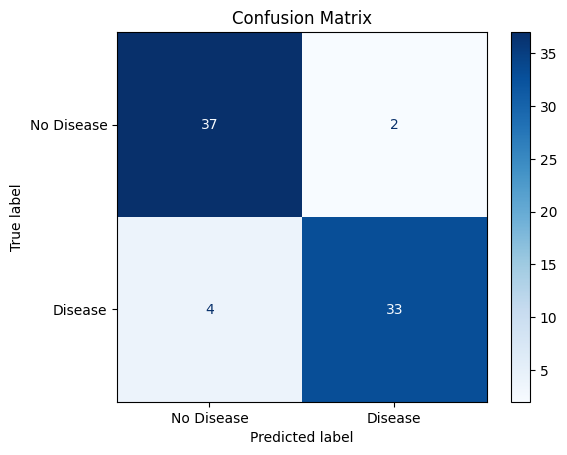

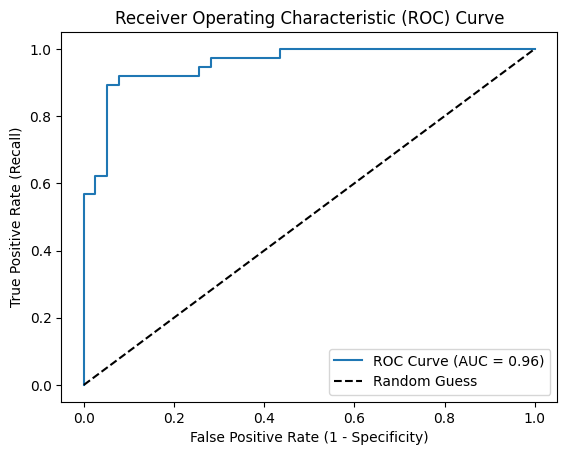

In [5]:
# Split the data into a test set to evaluate the best model
from sklearn.model_selection import train_test_split

_, X_test, _, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Get y_pred from the best model
y_pred = best_model.predict(X_test)

# Convert the probabilities to binary predictions
binary_y_pred = (y_pred > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, binary_y_pred)

# Extract TN, FP, FN, and TP
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
precision = precision_score(y_test, binary_y_pred)
recall = recall_score(y_test, binary_y_pred)
f1 = f1_score(y_test, binary_y_pred)
specificity = tn / (tn + fp)
roc_auc = roc_auc_score(y_test, y_pred)

# Print all metrics
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")

accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy:.2f}")

# Generate and display Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, binary_y_pred, display_labels=["No Disease", "Disease"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")
plt.show()